# Natural Language Processing: Week 3 - Sequence Models

자연어처리에서는 단어의 순서, 즉 sequence가 중요하게 작용한다.

기본적인 모델은 data와 label을 받아 rule을 output한다고 할 수 있는데, 여기에서는 sequence를 고려하지 않고 있음을 알 수 있다.

이와 달리 Sequence를 고려하는 모델을 만들고자 한 데에서 나온 아이디어는 RNN(Recurrent Neural Network)의 기본 아이디어가 되었다.

![image](https://user-images.githubusercontent.com/76294398/140466261-47fe0c13-07bc-4b9e-8f2e-5eec7f2a3e90.png)


## LSTMs

다음과 같은 문장이 있다고 생각해보자.

> Today has a beautiful blue <...>.

맥락상 <...>안에는 sky가 들어갈 것이라고 예측할 수 있다. 이는 빈칸 앞 문장의 맥락을 통해 파악한 것인데, 이것을 Context라고 하며, 이를 이용해 모델이 빈칸에 들어갈 말을 예측할 수 있게 할 수 있다.

RNN에서 앞선 문장의 Context가 전체로 이어지게 하는 Cell State라는 추가적인 파이프라인을 추가한 것이 바로 LSTM(Long-Short Term Memory unit)이다.

이는 양방향으로 작용하며 뒤 문장의 Context를 앞으로 가져와 빈칸을 채우기도 한다.

![image](https://user-images.githubusercontent.com/76294398/140467518-3970f216-6c86-47f5-b33a-8f66609012ac.png)

### IMDB Subwords 8K with Single Layer LSTM

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals # Pyhton3의 문법을 Python2에서도 사용가능하게 만들어주는 문법. Python3를 사용하고 있다면 굳이 실행시키지 않아도 된다.

import tensorflow_datasets as tfds
import tensorflow as tf

tf.__version__

'2.6.0'

In [2]:
# Get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompletePX378K/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompletePX378K/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompletePX378K/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
tokenizer = info.features['text'].encoder

In [4]:
# configuration
BUFFER_SIZE = 10_000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.summary() # Bidirectional이기에 64 * 2 = 128

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 171s 413ms/step - loss: 0.5280 - accuracy: 0.7391 - val_loss: 0.5171 - val_accuracy: 0.7632
Epoch 2/10
391/391 [==============================] - 161s 411ms/step - loss: 0.4294 - accuracy: 0.8132 - val_loss: 0.4489 - val_accuracy: 0.8004
Epoch 3/10
391/391 [==============================] - 164s 417ms/step - loss: 0.3263 - accuracy: 0.8717 - val_loss: 0.4254 - val_accuracy: 0.8308
Epoch 4/10
391/391 [==============================] - 165s 421ms/step - loss: 0.3100 - accuracy: 0.8789 - val_loss: 0.4736 - val_accuracy: 0.8381
Epoch 5/10
391/391 [==============================] - 166s 421ms/step - loss: 0.2728 - accuracy: 0.8936 - val_loss: 0.5543 - val_accuracy: 0.7141
Epoch 6/10
391/391 [==============================] - 166s 422ms/step - loss: 0.2792 - accuracy: 0.8852 - val_loss: 0.4420 - val_accuracy: 0.8221
Epoch 7/10
391/391 [==============================] - 165s 420ms/step - loss: 0.1885 - accuracy: 0.9306 - val_loss: 0.4991 -

#### Visualize

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

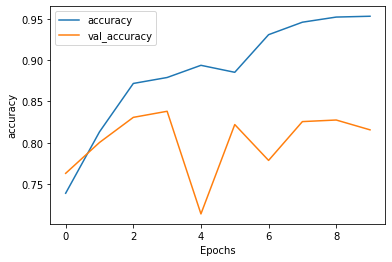

In [10]:
plot_graphs(history, 'accuracy')

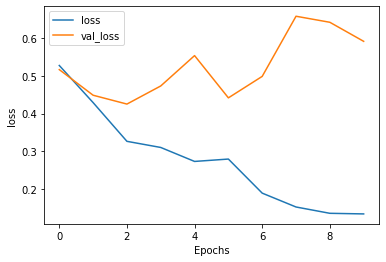

In [11]:
plot_graphs(history, 'loss')

### IMDB Subwords 8K with Multi Layer LSTM

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 324s 810ms/step - loss: 0.5542 - accuracy: 0.7132 - val_loss: 0.5333 - val_accuracy: 0.7594
Epoch 2/10
391/391 [==============================] - 314s 801ms/step - loss: 0.5523 - accuracy: 0.7219 - val_loss: 0.6533 - val_accuracy: 0.6374
Epoch 3/10
391/391 [==============================] - 314s 801ms/step - loss: 0.4482 - accuracy: 0.7978 - val_loss: 0.4618 - val_accuracy: 0.8005
Epoch 4/10
391/391 [==============================] - 314s 801ms/step - loss: 0.3969 - accuracy: 0.8276 - val_loss: 0.5056 - val_accuracy: 0.7694
Epoch 5/10
391/391 [==============================] - 311s 793ms/step - loss: 0.3405 - accuracy: 0.8628 - val_loss: 0.4585 - val_accuracy: 0.8049
Epoch 6/10
391/391 [==============================] - 310s 789ms/step - loss: 0.2837 - accuracy: 0.8894 - val_loss: 0.4283 - val_accuracy: 0.8161
Epoch 7/10
391/391 [==============================] - 312s 796ms/step - loss: 0.2577 - accuracy: 0.9027 - val_loss: 0.4311 -

#### Visualize

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

## Using a convolutional network

### IMDB Subwords 8K with 1D Convolutional Layer - Multiple Layer GRU

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

#### Visualize

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

### IMDB Reviews with GRU (and optional LSTM and Conv1D)

In [ ]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [ ]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

## Exploring different sequence models

### Sarcasm with Bidirectional LSTM

In [ ]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sarcasm.json
!gdown --id 1dRzdJS7-cZS4S5CuUc32MZYSLJGkkxnp

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

#### Visualize

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#### Model Save

In [ ]:
model.save("test.h5")

### Sarcasm with 1D Convolutional Layer

In [ ]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sarcasm.json
!gdown --id 1dRzdJS7-cZS4S5CuUc32MZYSLJGkkxnp

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

#### Visualize

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#### Model Save

In [ ]:
model.save("test2.h5")

## Week 3 Quiz

총점 8점

### 질문 1

Why does sequence make a large difference when determining semantics of language?

- Because the order in which words appear dictate their impact on the meaning of the sentence

## 질문 2

How do Recurrent Neural Networks help you understand the impact of sequence on meaning?

- They carry meaning from one cell to the next

### 질문 3
How does an LSTM help understand meaning when words that qualify each other aren’t necessarily beside each other in a sentence?

- Values from earlier words can be carried to later ones via a cell state

### 질문 4
What keras layer type allows LSTMs to look forward and backward in a sentence?

- Bidirectional

### 질문 5
What’s the output shape of a bidirectional LSTM layer with 64 units?

- (None, 128)

### 질문 6
When stacking LSTMs, how do you instruct an LSTM to feed the next one in the sequence?

- Ensure that return_sequences is set to True only on units that feed to another LSTM

### 질문 7
If a sentence has 120 tokens in it, and a Conv1D with 128 filters with a Kernal size of 5 is passed over it, what’s the output shape?

- (None, 116, 128)

### 질문 8
What’s the best way to avoid overfitting in NLP datasets?

- None of the above